In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import gym

In [2]:
!pip install numpy==1.24.3

In [3]:
train_env = gym.make('CartPole-v1')
test_env = gym.make('CartPole-v1')

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [4]:
SEED = 1234

train_env.seed(SEED);
test_env.seed(SEED+1);
np.random.seed(SEED);
torch.manual_seed(SEED);

/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [5]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout = 0.5):
        super().__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x

In [6]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()

        self.actor = actor
        self.critic = critic

    def forward(self, state):

        action_pred = self.actor(state)
        value_pred = self.critic(state)

        return action_pred, value_pred

In [7]:
INPUT_DIM = train_env.observation_space.shape[0]
HIDDEN_DIM = 128
OUTPUT_DIM = train_env.action_space.n

actor = MLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM)
critic = MLP(INPUT_DIM, HIDDEN_DIM, 1)

policy = ActorCritic(actor, critic)

In [8]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

In [9]:
policy.apply(init_weights)

ActorCritic(
  (actor): MLP(
    (fc_1): Linear(in_features=4, out_features=128, bias=True)
    (fc_2): Linear(in_features=128, out_features=2, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (critic): MLP(
    (fc_1): Linear(in_features=4, out_features=128, bias=True)
    (fc_2): Linear(in_features=128, out_features=1, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [10]:
LEARNING_RATE = 0.01

optimizer = optim.Adam(policy.parameters(), lr = LEARNING_RATE)

In [11]:
def train(env, policy, optimizer, discount_factor, trace_decay):

    policy.train()

    log_prob_actions = []
    values = []
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        action_pred, value_pred = policy(state)

        action_prob = F.softmax(action_pred, dim = -1)

        dist = distributions.Categorical(action_prob)

        action = dist.sample()

        log_prob_action = dist.log_prob(action)

        state, reward, done, _ = env.step(action.item())

        log_prob_actions.append(log_prob_action)
        values.append(value_pred)
        rewards.append(reward)

        episode_reward += reward

    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values).squeeze(-1)

    returns = calculate_returns(rewards, discount_factor)
    #note: calculate_advantages takes in rewards, not returns!
    advantages = calculate_advantages(rewards, values, discount_factor, trace_decay)

    policy_loss, value_loss = update_policy(advantages, log_prob_actions, returns, values, optimizer)

    return policy_loss, value_loss, episode_reward

In [12]:
class AdaptiveKalman:
    def __init__(self, Q=1e-1, R=1.0, alpha=0.9):
        self.x = 0.0  # 均值估计
        self.P = 1.0  # 协方差
        self.Q = Q
        self.R = R
        self.alpha = alpha

    def update(self, z):
        self.P += self.Q
        K = self.P / (self.P + self.R)
        residual = z - self.x
        self.x += K * residual
        self.P *= (1 - K)
        self.R = self.alpha * self.R + (1 - self.alpha) * (residual ** 2)
        return self.x, self.P

In [13]:
"""
def calculate_returns(rewards, discount_factor, normalize = True):

    returns = []
    R = 0

    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)

    returns = torch.tensor(returns)

    if normalize:

        returns = (returns - returns.mean()) / returns.std()

    return returns

"""
def calculate_returns(rewards, discount_factor, normalize=True):
    returns = []
    R = 0

    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)

    returns = torch.tensor(returns, dtype=torch.float32)

    if normalize:
        kalman = AdaptiveKalman()
        for r in returns:
            mean_estimate, var_estimate = kalman.update(r.item())
        std_estimate = (var_estimate ** 0.5) + 1e-8
        returns = (returns - mean_estimate) / std_estimate

    return returns

In [14]:
"""
class SimpleKalman:
    def __init__(self, process_noise=1e-4, obs_noise=1e-2):
        self.x = 0.0          # 状态估计
        self.P = 1.0          # 状态协方差
        self.Q = process_noise
        self.R = obs_noise

    def update(self, z):
        # 预测
        x_pred = self.x
        P_pred = self.P + self.Q

        # 更新
        K = P_pred / (P_pred + self.R)  # 卡尔曼增益
        self.x = x_pred + K * (z - x_pred)
        self.P = (1 - K) * P_pred
        return self.x, self.P

def calculate_returns(rewards, discount_factor, normalize=True):
    returns = []
    R = 0

    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)

    returns = torch.tensor(returns, dtype=torch.float32)

    if normalize:
        kalman = SimpleKalman()
        for r in returns:
            mean_estimate, var_estimate = kalman.update(r.item())
        std_estimate = (var_estimate ** 0.5) + 1e-8
        returns = (returns - mean_estimate) / std_estimate

    return returns
"""

'\nclass SimpleKalman:\n    def __init__(self, process_noise=1e-4, obs_noise=1e-2):\n        self.x = 0.0          # 状态估计\n        self.P = 1.0          # 状态协方差\n        self.Q = process_noise\n        self.R = obs_noise\n\n    def update(self, z):\n        # 预测\n        x_pred = self.x\n        P_pred = self.P + self.Q\n\n        # 更新\n        K = P_pred / (P_pred + self.R)  # 卡尔曼增益\n        self.x = x_pred + K * (z - x_pred)\n        self.P = (1 - K) * P_pred\n        return self.x, self.P\n\ndef calculate_returns(rewards, discount_factor, normalize=True):\n    returns = []\n    R = 0\n\n    for r in reversed(rewards):\n        R = r + R * discount_factor\n        returns.insert(0, R)\n\n    returns = torch.tensor(returns, dtype=torch.float32)\n\n    if normalize:\n        kalman = SimpleKalman()\n        for r in returns:\n            mean_estimate, var_estimate = kalman.update(r.item())\n        std_estimate = (var_estimate ** 0.5) + 1e-8\n        returns = (returns - mean_estimate

In [15]:
def calculate_advantages(rewards, values, discount_factor, trace_decay, normalize = True):

    advantages = []
    advantage = 0
    next_value = 0

    for r, v in zip(reversed(rewards), reversed(values)):
        td_error = r + next_value * discount_factor - v
        advantage = td_error + advantage * discount_factor * trace_decay
        next_value = v
        advantages.insert(0, advantage)

    advantages = torch.tensor(advantages)

    if normalize:
        advantages = (advantages - advantages.mean()) / advantages.std()

    return advantages

In [16]:
def update_policy(advantages, log_prob_actions, returns, values, optimizer):

    advantages = advantages.detach()
    returns = returns.detach()

    policy_loss = - (advantages * log_prob_actions).sum()

    value_loss = F.smooth_l1_loss(returns, values).sum()

    optimizer.zero_grad()

    policy_loss.backward()
    value_loss.backward()

    optimizer.step()

    return policy_loss.item(), value_loss.item()

In [17]:
def evaluate(env, policy):

    policy.eval()

    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0)

        with torch.no_grad():

            action_pred, _ = policy(state)

            action_prob = F.softmax(action_pred, dim = -1)

        action = torch.argmax(action_prob, dim = -1)

        state, reward, done, _ = env.step(action.item())

        episode_reward += reward

    return episode_reward

In [18]:
MAX_EPISODES = 500
DISCOUNT_FACTOR = 0.99
TRACE_DECAY = 0.99
N_TRIALS = 25
REWARD_THRESHOLD = 475
PRINT_EVERY = 10

train_rewards = []
test_rewards = []



for episode in range(1, MAX_EPISODES+1):

    policy_loss, critic_loss, train_reward = train(train_env, policy, optimizer, DISCOUNT_FACTOR, TRACE_DECAY)

    test_reward = evaluate(test_env, policy)

    train_rewards.append(train_reward)
    test_rewards.append(test_reward)

    mean_train_rewards = np.mean(train_rewards[-N_TRIALS:])
    mean_test_rewards = np.mean(test_rewards[-N_TRIALS:])

    if episode % PRINT_EVERY == 0:

        print(f'| Episode: {episode:3} | Mean Train Rewards: {mean_train_rewards:5.1f} | Mean Test Rewards: {mean_test_rewards:5.1f} |')

    if mean_test_rewards >= REWARD_THRESHOLD:

        print(f'Reached reward threshold in {episode} episodes')

        break

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


| Episode:  10 | Mean Train Rewards:  34.6 | Mean Test Rewards: 197.6 |
| Episode:  20 | Mean Train Rewards:  43.9 | Mean Test Rewards: 132.8 |
| Episode:  30 | Mean Train Rewards:  68.1 | Mean Test Rewards: 238.0 |
| Episode:  40 | Mean Train Rewards:  98.6 | Mean Test Rewards: 281.3 |
| Episode:  50 | Mean Train Rewards: 106.5 | Mean Test Rewards: 244.7 |
| Episode:  60 | Mean Train Rewards:  78.1 | Mean Test Rewards:  97.7 |
| Episode:  70 | Mean Train Rewards:  55.0 | Mean Test Rewards:  70.2 |
| Episode:  80 | Mean Train Rewards:  51.4 | Mean Test Rewards:  64.5 |
| Episode:  90 | Mean Train Rewards:  60.0 | Mean Test Rewards:  68.8 |
| Episode: 100 | Mean Train Rewards:  92.2 | Mean Test Rewards: 138.4 |
| Episode: 110 | Mean Train Rewards: 116.7 | Mean Test Rewards: 164.6 |
| Episode: 120 | Mean Train Rewards: 114.9 | Mean Test Rewards: 162.3 |
| Episode: 130 | Mean Train Rewards: 105.3 | Mean Test Rewards: 128.7 |
| Episode: 140 | Mean Train Rewards: 132.1 | Mean Test Rewards: 

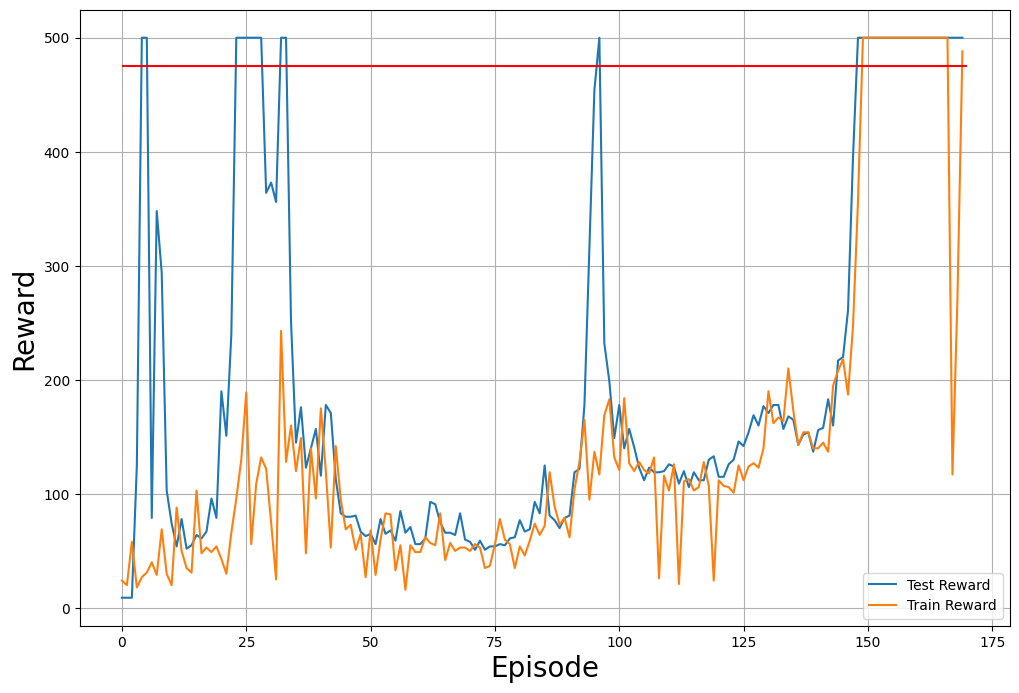

In [19]:
plt.figure(figsize=(12,8))
plt.plot(test_rewards, label='Test Reward')
plt.plot(train_rewards, label='Train Reward')
plt.xlabel('Episode', fontsize=20)
plt.ylabel('Reward', fontsize=20)
plt.hlines(REWARD_THRESHOLD, 0, len(test_rewards), color='r')
plt.legend(loc='lower right')
# plt.savefig("z_mean_cartpole_gae.png", dpi=300)
plt.grid()
